In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from keras.models import Model
from keras import backend as K
from utils.helper import heatmap
from innvestigate import utils as iutils
import os
from keras.preprocessing.image import img_to_array, load_img
from utils.fileutils import CacheStorage

os.environ["CUDA_VISIBLE_DEVICES"]="3"

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from utils.evaluations import get_validation_dataflow
from utils.evaluations import get_validation_data, ImageNetPreprocessGenerator
from utils.evaluations import get_averaged_validation_image, get_saliency_maps, get_predkeeper

In [4]:
valid_data_dir = Path("./data/ILSVRC2012_val/img_centercrop/")
val_imgs, val_labels = get_validation_data(valid_data_dir)
print(val_imgs.shape)
print(val_labels.shape)

Try to load cache file
(50000, 224, 224, 3)
(50000, 1000)


In [5]:
model = VGG19(weights="imagenet")
model.compile(
    loss='categorical_crossentropy',
    optimizer='SGD',
    metrics=["accuracy", "top_k_categorical_accuracy"],
)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
partial_model = Model(
    inputs=model.inputs,
    outputs=iutils.keras.graph.pre_softmax_tensors(model.outputs),
    name=model.name,
)

In [8]:
partial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
input_imgs = val_imgs #preprocess_input(val_imgs) #for built in keras models

In [10]:
min_input = np.min(val_imgs)
max_input = np.max(val_imgs)
input_shape = val_imgs.shape
num_classes = val_labels.shape[1]

In [11]:
def unpreprocess(x):
    x = np.copy(x)
    # undo preprocesing
    mean = [103.939, 116.779, 123.68]
    x[:,:,0] += mean[0]
    x[:,:,1] += mean[1]
    x[:,:,2] += mean[2]
    x = x[..., ::-1]
    return x.astype(int)

In [12]:
averaged_X = input_imgs.mean(axis=0)

In [13]:
random_X = np.random.uniform(0, 255, (input_shape[1], input_shape[2], input_shape[3]))
random_X = preprocess_input(random_X)

In [14]:
cache = CacheStorage()
print("Try to load cache file")
predictions = cache.get_cache(os.path.join('cache', "imagenet_predictions"))
if predictions is None:
    print("Making cache file")
    predictions = model.predict(input_imgs)
    cache.set_cache(os.path.join('cache', "imagenet_predictions"), predictions)

Try to load cache file


In [15]:
from utils.visualizations import GradCAM, GuidedGradCAM, GBP, LRP, CLRP, SGLRP, SGLRP2
from tqdm import tqdm

In [16]:
from utils.visualizations_working import LRPA, IG, SG, IxG, Decon, LRPA, LRPB, LRPE, LRPA2B1, DL

In [17]:
def define_mask(row, col):
#         print(row, col)
    top = row - 9 // 2
    bottom = row + 9 // 2 + 1
    left = col - 9 // 2
    right = col + 9 // 2 + 1

    if top < 0:
        top = 0
    if bottom > input_shape[1] - 1:
        bottom = input_shape[1] - 1
    if left < 0:
        left = 0
    if right > input_shape[2] - 1:
        right = input_shape[2] - 1
    return top, bottom, left, right

In [19]:
num_iters = 100

num_classes = 100 #1000

num_per_class = 50


limit = num_classes * num_per_class

every = 10


gt = np.argmax(val_labels[:limit], axis=1)

In [20]:
   
def show_image(img):
    plt.imshow(unpreprocess(img))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

In [21]:
verbose = 0
random_or_average = "random"

In [22]:
store_dir = os.path.join("maps", "imagenet")

In [23]:
import itertools
def get_maps(network, method):
    npz_path_list = [os.path.join(store_dir, "%d_%d_%s_%s.npz"%(c, i, network, method)) for c, i in itertools.product(range(1000), range(50))]
    saliency_maps = np.array([np.load(npz_path)["x"] for npz_path in tqdm(npz_path_list)])
#     print(npz_path_list)
    return saliency_maps
# get_maps("vgg19", "lrp")

In [24]:
method = "lrpa"
orig_maps = get_maps("vgg19", method)

In [25]:
# print("Try to load cache file")
# orig_maps = cache.get_cache(os.path.join('cache', "lrp_maps_gt_imagenet"))
# if orig_maps is None:
#     print("Making cache file")
#     orig_maps = get_maps("vgg19", "lrpa")
#     cache.set_cache(os.path.join('cache', "lrp_maps_gt_imagenet"), orig_maps)

Try to load cache file


array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [27]:
def run_change_in_y_t(model, targets, images, maps, num_iters, random_X, averaged_X):
    input_shape = images.shape
    ret = np.zeros((limit, int(num_iters / every + 1)))
    for example_id, target_id in enumerate(tqdm(targets)):
        modified_images = np.zeros((num_iters+1, input_shape[1], input_shape[2], input_shape[3]))
        modified_images[0] = np.copy(images[example_id])
        current_map = np.copy(maps[example_id])
        ret[example_id,0] = predictions[example_id, target_id]
        for i in np.arange(1,num_iters+1):
            row, col = np.unravel_index(current_map.argmax(), current_map.shape)

            # wipe out used
            current_map[row, col] = 0

            top, bottom, left, right = define_mask(row, col)
            modified_images[i] = modified_images[i-1]
            if random_or_average == "random":
                modified_images[i, top:bottom, left:right] = random_X[top:bottom, left:right]
            else:
                modified_images[i, top:bottom, left:right] = averaged_X[top:bottom, left:right]
#             if i == 99:
#                 print(top, bottom, left, right)
#                 show_image(modified_images[i])
        sampled_images = modified_images[np.arange(every,num_iters+1,every)]
        ret[example_id,1:] = model.predict(sampled_images)[:,target_id]
    return ret

In [28]:
results = run_change_in_y_t(model, gt, input_imgs[:limit], orig_maps, num_iters, random_X, averaged_X)

100%|██████████| 5000/5000 [2:06:00<00:00,  1.51s/it]  


In [ ]:
# print("Try to load cache file")
# results = cache.get_cache(os.path.join('cache', "change_yt_lrp_gt_imagenet"))
# if results is None:
#     print("Making cache file")
#     results = run_change_in_y_t(model, gt, input_imgs[:limit], orig_maps, num_iters, random_X, averaged_X)
#     cache.set_cache(os.path.join('cache', "change_yt_lrp_gt_imagenet"), results)

NameError: name 'method' is not defined

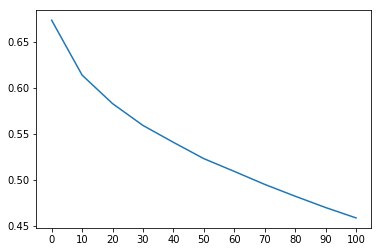

In [29]:
ave_results = np.mean(results, axis=0)

plt.plot(np.arange(num_iters / every +1), ave_results)
plt.xticks(np.arange(num_iters / every +1), np.arange(0, num_iters + 1, every))
plt.savefig(os.path.join("output", "zchange_%s_every%d.pdf"%(method, every)))


In [ ]:
#aopc
aopc = 1./(num_iters+1.)*np.cumsum(np.interp(np.arange(num_iters), np.arange(0, num_iters + 1, every), ave_results))
plt.plot(np.arange(num_iters), aopc)
# plt.xticks(np.arange(num_iters / every +1), np.arange(0, num_iters + 1, every))
plt.savefig(os.path.join("output", "aopc_%s_every%d.pdf"%(method, every)))

In [ ]:
np.savez_compressed(os.path.join("output", "results_%s_every%d"%(method, every)), ave=ave_results, aopc=aopc)